# Exercises

In [23]:
#prepare code for exercise

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

In [24]:
duration = 50.
dt = .1
std_dev = 1
vf_size = (15,15)
n_bins = round(duration / float(dt))


S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])

size = vf_size # size in pixel of our receptive field
mu = (8, 8) # center of the gabor pathc
sigma = (4,4) #size of the gabor patch
angle = 45 # orientation of the gabor patch
frequency = .085 # spatial frequency of the gabor patch
phase = 0 # pahse of the gabor pathc


xx, yy = np.meshgrid(1. + np.arange(size[0]),
                         1. + np.arange(size[1]))

# Gaussian envelope
G = np.exp(- np.power(xx - mu[0], 2) / (2. * sigma[0])
            - np.power(yy - mu[1], 2) / (2. * sigma[1]))

# spatial modulation
phi = np.deg2rad(angle)
xxr = xx * np.cos(phi)
yyr = yy * np.sin(phi)
xyr = (xxr + yyr) * 2. * np.pi * 2. * frequency
Sn = np.cos(xyr + phase)

K = G * Sn
K /= np.amax(np.abs(K))



noise_variance = 1
offset = 2.

# flatten the matrices in to 1d array for convenience
K_flat = K.ravel()
K_flat = np.hstack((K.flat, offset))

S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))


# 1. linear stage
ks = np.dot(K_flat, S_flat.T)

# 2. nonlinear stage (for a linear model: f -> identity function)
rate = ks

# add Gaussian noise centered around the "true" rate for each bin
rate = rate + np.sqrt(noise_variance) * np.random.randn(n_bins)


In [25]:
#S_flat = S_flat.T
K_hat = np.linalg.pinv(S_flat.T @ S_flat) @ (S_flat.T @ rate)
K_hat = K_hat[:-1].reshape(vf_size)
cc = np.inner(K_flat[:-1], K_hat.ravel()) / (np.linalg.norm(K_flat[:-1]) * np.linalg.norm(K_hat.ravel()))


## Exercise 1
---
Determine the effect of stimulus sequence duration on RF estimates. To do this, repeat the above steps for different durations (5 s, 10 s, 20 s, 40 s, 80 s, 160 s, 320 s, 640 s). Compute the Pearson correlation between true and estimated RFs for each duration to quantify the accuracy of the estimator. The Pearson correlation $\mathrm{cc}$ is defined as
$$
\mathrm{cc} = \frac{\mathbf{k}_\mathrm{true}^T \hat{\mathbf{k}}}{\lVert \mathbf{k}_\mathrm{true} \rVert \lVert \hat{\mathbf{k}} \rVert}
$$
where $\lVert \cdot \rVert$ is the L2-norm (vector length).
As the response generation process is stochastic, compute the average correlation across 10 realizations for the same duration and plot the average correlation as a function of duration. How is the recording duration related to the ability to recover the true RF? 

For this chapter, I chose to make all exercises

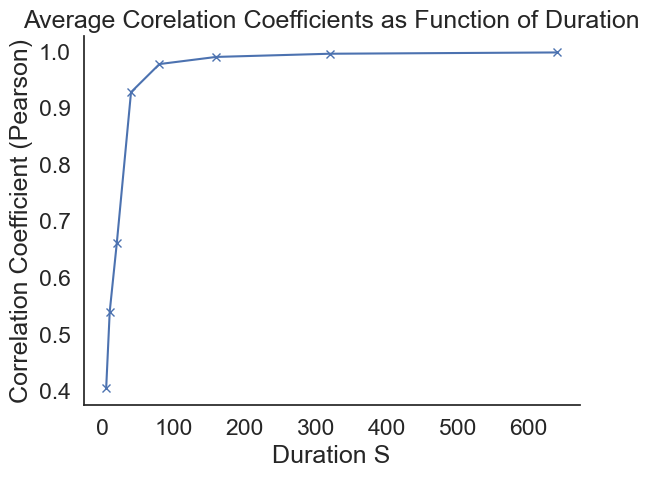

In [26]:
durations = np.array([5, 10, 20, 40, 80, 160, 320, 640])
n_realization = 10
corravg = np.zeros(len(durations))

for i in range(len(durations)):
    duration = durations[i]
    correlations = np.zeros(n_realization)
    
    for j in range(n_realization):
        # Create new S
        n_bins = round(duration / float(dt))
        S = std_dev * np.random.randn(n_bins, vf_size[0], vf_size[1])
        S_flat = S.reshape(S.shape[0], S.shape[1] * S.shape[2])
        S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))
        # Actual response
        ks = np.dot(K_flat, S_flat.T)
        rate = ks + np.sqrt(noise_variance) * np.random.randn(n_bins)
        # Fit GLM
        K_hat = np.linalg.pinv(S_flat.T @ S_flat) @ (S_flat.T @ rate)
        K_hat = K_hat[:-1].reshape(vf_size)
        # Calculate correlations
        correlations[j] = np.inner(K_flat[:-1], K_hat.ravel()) / (
                    np.linalg.norm(K_flat[:-1]) * np.linalg.norm(K_hat.ravel()))

    corravg[i] = np.mean(correlations)

# Plotting result
plt.plot(durations, corravg, marker='x')
plt.xlabel('Duration S')
plt.ylabel('Correlation Coefficient (Pearson)')
plt.title('Average Corelation Coefficients as Function of Duration')
plt.show()

As the stimulus sequence duration increases, the pearson cc sharply increases and reaches a plateau/asymptote, when it hits 1, a perfect correlation is indicated. When the duration is short, as in, less spikes are recorded, there is less information available to estimate the RF of the neurons. This is in part due to the stochastic nature of neuronal spike train recordings of many neurons. As the duration becomes larger, this stochastic nature becomes more apperant and provides additional information to form clear correlation which allows for the receptive field to be more accurately modelled. 

## Exercise 2
---
Determine the effect of response noise ($\sigma^2$) on RF estimates. Try different value for the noise variance in the simulations, e.g., 0, 2, 4, 6, 8, and 10 for a duration of 100 s. As in the previous excercise, repeatedly estimate RF parameters for each condition (10 times) but this time also plot the standard deviation of the correlations across the different runs for each condition.

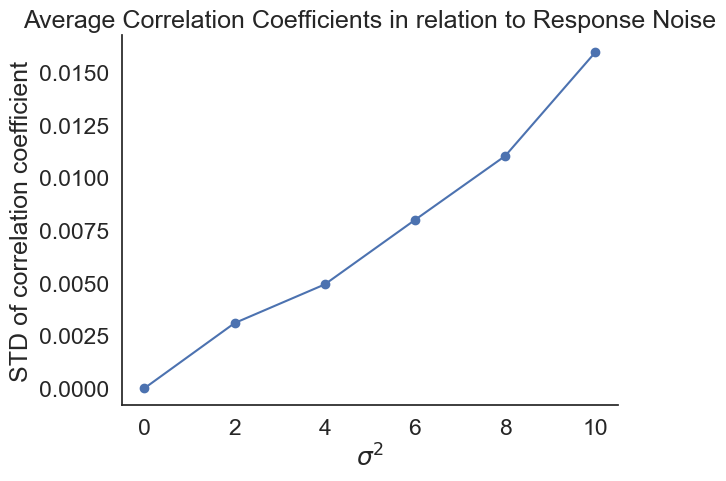

In [27]:
#determine parameters

duration = 100
noise_variances = np.array([0,2,4,6,8,10])
num_realizations = 10
correlations_avg = np.zeros(len(noise_variances))

for i in range(len(noise_variances)):
    noise_variance = noise_variances[i]
    correlations = np.zeros(num_realizations)
    
    for j in range(num_realizations):
        # Create new S
        n_bins = round(duration / float(dt))
        S = std_dev * np.random.randn(n_bins, vf_size[0], vf_size[1])
        S_flat = S.reshape(S.shape[0], S.shape[1] * S.shape[2])
        S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))

        # Actual response
        ks = np.dot(K_flat, S_flat.T)
        rate = ks + np.sqrt(noise_variances[i]) * np.random.randn(n_bins)

        # Fit GLM
        K_hat = np.linalg.pinv(S_flat.T @ S_flat) @ (S_flat.T @ rate)
        K_hat = K_hat[:-1].reshape(vf_size)

        # Calculate correlations
        correlations[j] = np.inner(K_flat[:-1], K_hat.ravel()) / (
                    np.linalg.norm(K_flat[:-1]) * np.linalg.norm(K_hat.ravel()))
        
    #substitute np.mean for no.std to get the standard deviation
    correlations_avg[i] = np.std(correlations)

# Plotting average correlations as a function of duration
plt.plot(noise_variances, correlations_avg, marker='o')
plt.xlabel('$\sigma^2$')
plt.ylabel('STD of correlation coefficient')
plt.title('Average Correlation Coefficients in relation to Response Noise')
plt.show()

There is a decrease in the pearson correlation coefficient with increaase in the response noise (using np.mean). Substituting np.mean for np.std gives me the standard deviation. I have plotted the standard deviation of the pearson correlation coefficient against the effect of reponse noise. There is an increase in the standard deviation of the correlation coefficient with an increase in response noise, it seems to hit a plateau around 10 but more datapoints are needed to confirm this. 

when increasing the duration from 10 to 100 seconds I see a difference in the pearson correlation trend. If we increase the duration of the data we can increase the accuracy due to more data being available giving a better estimation of the RF. 

## Exercise 3
---
Look at the analytical derivation of the log-likelihood for the poisson GLM.
Which of the terms are required for maximizing the likelihood with respect to $\mathbf{k}$ and which terms can be ignored? **Note:** due to the independence of spikes in the different bins, the likelihood can be written as $P(R | S, \mathbf{k}) = \prod_t^T P(r_t | \mathbf{s}_t, \mathbf{k})$. The log turns the product into a sum which makes life much easier. 




After using an LLM to rewrite the GLM algorithm we can determine which terms are dependant/infuencing K

rewritten formula:
$ \log P(R | S, \mathbf{k}) = \sum_{t=1}^T \left( r_t \mathbf{s}_t^T \mathbf{k} - e^{\mathbf{s}_t^T \mathbf{k}} - \log(r_t!) \right) $

To maximize the log-likelihood with respect to $\mathbf{k}$, we need to identify which terms depend on $\mathbf{k}$

$r_t \mathbf{s}_t^T \mathbf{k}$: This term depends on $\mathbf{k}$ and is required for maximizing the likelihood.

$- e^{\mathbf{s}_t^T \mathbf{k}}$: This term also depends on $\mathbf{k}$ and is required for maximizing the likelihood.

$- \log(r_t!)$: This term does not depend on $\mathbf{k}$ and thus can be ignored when maximizing the likelihood with respect to $\mathbf{k}$.


The $- \log(r_t!)$ term can be ignored as it does not affect the optimization with respect to $\mathbf{k}$.

## Exercise 4
---
Explore the effect of the data duration and the firing rate on the goodness of fit of the Poisson GLM.

A - Generate data with durations of 10,20,50,100 and 200 seconds. Fit the model on each dataset and plot the fitted parameters.
Use the pearson correlation as a proxy of the goodness of fit, and plot it as a function of the duration of the data.

B - Fix the duration to 100s, and change the average firing rate of the simulation. How does the fit perform for different firing rates? 

Answer to 4A

In [28]:
from scipy.optimize import minimize

# define functions

def cost(k, spike_counts, S,alpha=1):
    #negative log likelyhood function to minimize
    ks = np.dot(k, S.T)
    lamda = np.exp(ks)
    return -np.dot(spike_counts, ks) + dt * np.sum(lamda)
    
    
def grad(k, spike_counts, S):
    # expression of the gradient of the negative log likelyhood 
    
    ks = np.dot(k, S.T)
    lamda = np.exp(ks)
    return -np.dot(S.T, spike_counts - dt*lamda)

def generate_inhomogeneous_poisson_spikes(lamda, dt):

    n_bins = lamda.shape[0]
    bins = np.arange(n_bins+1)*dt

    # generate Poisson distributed numbers for all bins with the max. intensity (lamda_max)
    lamda_max = np.max(lamda)
    poisson_numbers = np.random.poisson(lamda_max, size=n_bins)

    # throw away numbers depending on the actual intensity ("thinning")
    spike_times = []
    prob = lamda / lamda_max
    for i in range(n_bins):
        
        # number of spikes to keep in this bin
        n = np.sum(np.random.rand(poisson_numbers[i]) < prob[i])
        n_s = int(round(n * dt))

        # generate random spike times in this bin
        ts = bins[i] + np.random.rand(n_s)*dt

        spike_times.extend(ts)

    return np.asarray(spike_times)

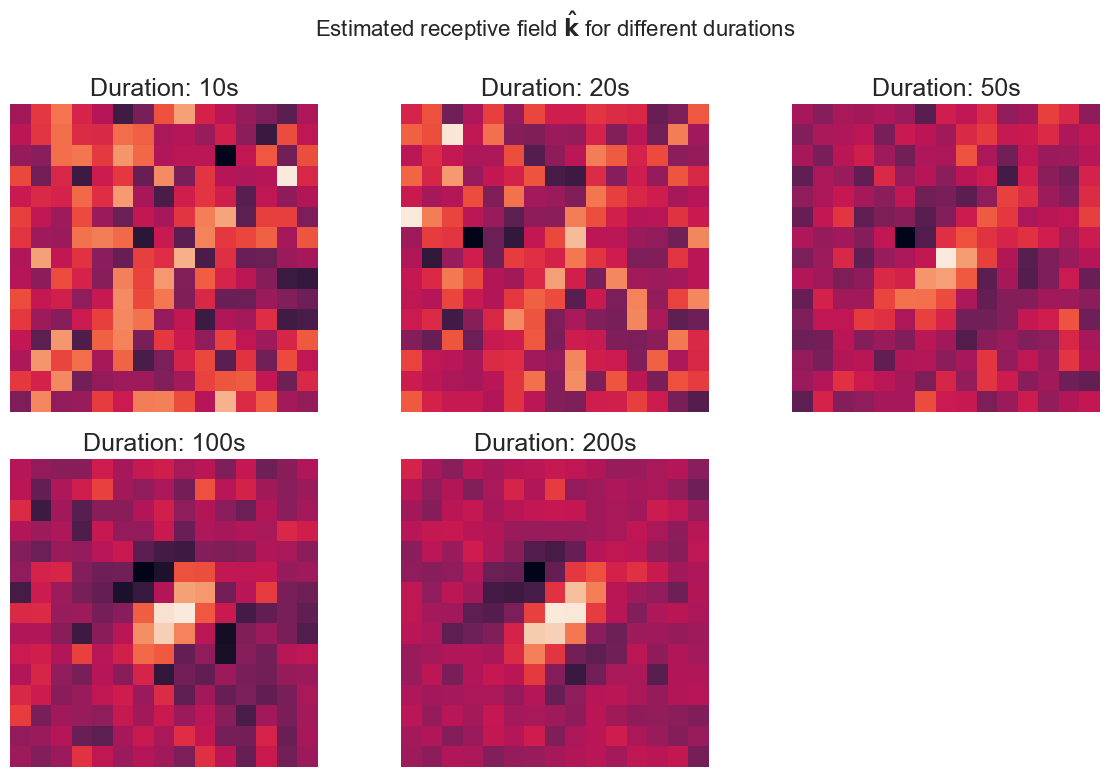

Text(0.5, 1.0, 'Average Correlation Coefficients vs Duration of S')

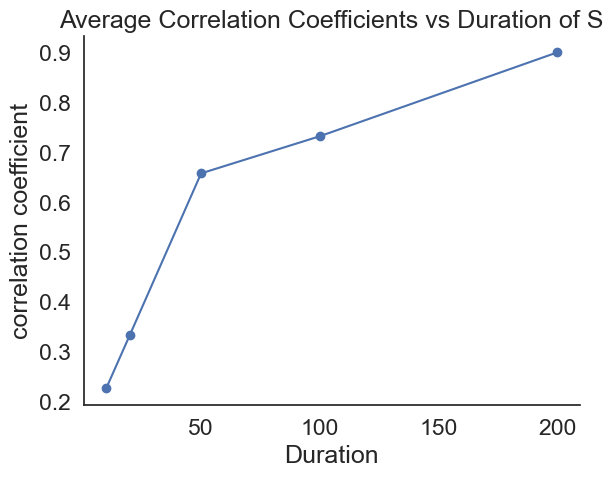

In [29]:
durations = np.array([10,20,50,100,200])
dt = .1
std_dev = 1
vf_size = (15,15)
n_bins = round(duration / float(dt))
spike_rate = 5 # average firing rate 

#store all K matrices for plotting later
K_est_matrices = np.zeros((15,15,len(durations)))

#store correlations
correlations = np.zeros(len(durations))

for i in range(len(durations)):
    duration = durations[i]
    n_bins = round(duration / float(dt))
    #generate stimulus
    S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])
    S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
    S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))
    #actual response
    ks = np.dot(K_flat, S_flat.T)
    lamda = np.exp(ks)
    expected_rate = np.sum(lamda*dt) / duration
    lamda *= (spike_rate / expected_rate)
    #poisson process
    spike_times = generate_inhomogeneous_poisson_spikes(lamda, dt)
    spike_counts = np.histogram(spike_times,bins=np.arange(n_bins+1)*dt)[0]
    #fit GLM
    k_STA = np.inner(S_flat.T, spike_counts) / np.sum(spike_counts)
    res = minimize(fun = cost, x0 = k_STA / 10, args = (spike_counts, S_flat), method = 'Newton-CG', jac = grad)
    K_est = res.x
    K_est_matrices[:,:,i] = K_est[:-1].reshape(15, 15)
    correlations[i] = np.inner(K.ravel(), K_est[:-1]) / (np.linalg.norm(K.ravel()) * np.linalg.norm(K_est[:-1]))
    
#plotting K
fig = plt.figure(figsize=(12, 8))

for i in range(len(durations)):
    plt.subplot(2, 3, i+1)
    plt.imshow(K_est_matrices[:,:,i])
    plt.title('Duration: {}s'.format(durations[i]))
    plt.axis('off')

plt.suptitle('Estimated receptive field $\mathbf{\hat{k}}$ for different durations', fontsize=16)
plt.tight_layout()
plt.show()

#plotting cc
plt.plot(durations, correlations,marker='o')
plt.xlabel('Duration')
plt.ylabel('correlation coefficient')
plt.title('Average Correlation Coefficients vs Duration of S')

Intuitively, the correlation coefficient increases with duration. We can clearly see the receptive field sizes becoming more established with increased duration, there is more data information for the GLM to work and establish the RF.

Answer to 4B

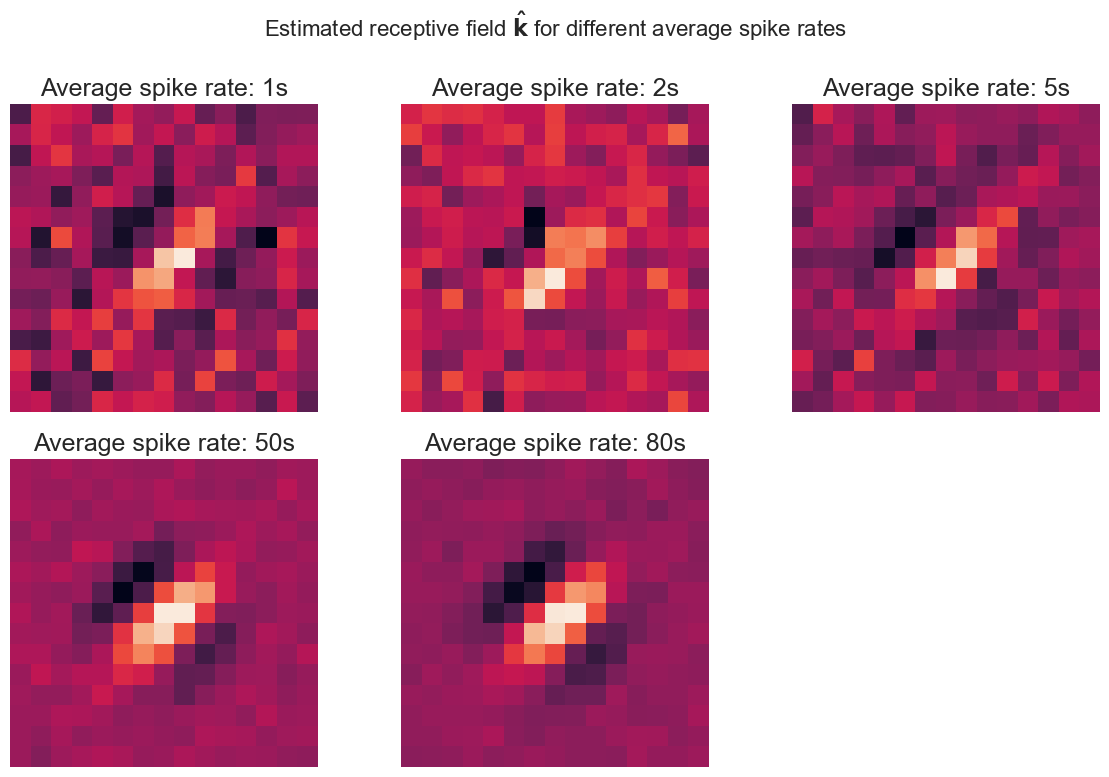

Text(0.5, 1.0, 'Average Correlation Coefficients vs Average Spike Rate')

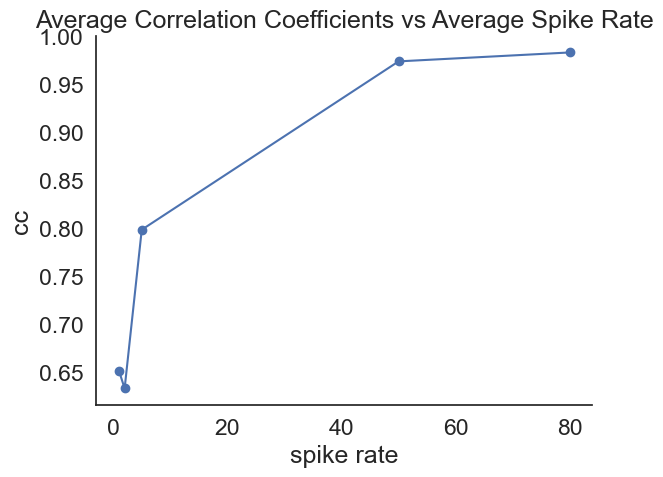

In [34]:
#determine parameters
duration = 100
dt = .1
std_dev = 1
vf_size = (15,15)
n_bins = round(duration / float(dt))
spike_rates = np.array([1,2,5,50,80]) # average firing rate 

#store all K matrices for plotting later
K_est_matrices = np.zeros((15,15,len(durations)))

#store correlations
correlations = np.zeros(len(durations))
    
for i in range(len(durations)):
    #generate stimulus
    S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])
    S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
    S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))
    #actual response
    ks = np.dot(K_flat, S_flat.T)
    lamda = np.exp(ks)
    expected_rate = np.sum(lamda*dt) / duration
    lamda *= (spike_rates[i] / expected_rate)
    #poisson process
    spike_times = generate_inhomogeneous_poisson_spikes(lamda, dt)
    spike_counts = np.histogram(spike_times,bins=np.arange(n_bins+1)*dt)[0]
    #fit GLM
    k_STA = np.inner(S_flat.T, spike_counts) / np.sum(spike_counts)
    res = minimize(fun = cost, x0 = k_STA / 10, args = (spike_counts, S_flat), method = 'Newton-CG', jac = grad)
    K_est = res.x
    K_est_matrices[:,:,i] = K_est[:-1].reshape(15, 15)
    correlations[i] = np.inner(K.ravel(), K_est[:-1]) / (np.linalg.norm(K.ravel()) * np.linalg.norm(K_est[:-1]))
    
#plotting K
fig = plt.figure(figsize=(12, 8))

for i in range(len(durations)):
    plt.subplot(2, 3, i+1)
    plt.imshow(K_est_matrices[:,:,i])
    plt.title('Average spike rate: {}s'.format(spike_rates[i]))
    plt.axis('off')
    
plt.suptitle('Estimated receptive field $\mathbf{\hat{k}}$ for different average spike rates', fontsize=16)
plt.tight_layout()
plt.show()


#plotting cc
plt.plot(spike_rates, correlations,marker='o')
plt.xlabel('spike rate')
plt.ylabel('cc')
plt.title('Average Correlation Coefficients vs Average Spike Rate')

Similarly to increasing the duration, increasing the spike rate intiuitively allows for more information to be used during the establishment of the estimated receptive field.The correlation coefficient increases sharply, reaching a peak.